In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
df_application_train = pd.read_csv("../data/application_train.csv")

In [3]:
df_credit_card_balance = pd.read_csv("../data/credit_card_balance.csv")

df_credit_features = df_credit_card_balance.groupby("SK_ID_CURR").agg({
    "AMT_PAYMENT_CURRENT": ["sum", "std"],
    "AMT_BALANCE": ["std"],
    "AMT_CREDIT_LIMIT_ACTUAL": ["mean"],
    "CNT_DRAWINGS_ATM_CURRENT": ["sum"],
    "SK_DPD": ["sum"],
    "SK_DPD_DEF": ["sum"],
    "CNT_INSTALMENT_MATURE_CUM": ["sum"],
    "CNT_DRAWINGS_CURRENT": ["sum"],
    "AMT_TOTAL_RECEIVABLE": ["sum"],
    "AMT_INST_MIN_REGULARITY": ["mean"],
    "AMT_DRAWINGS_CURRENT": ["sum", "mean", "std"],
    "AMT_DRAWINGS_POS_CURRENT": ["sum", "mean", "std"]
})

df_credit_features.columns = ['_'.join(col).upper() for col in df_credit_features.columns]
df_credit_features = df_credit_features.reset_index()


In [4]:
df_application_train = df_application_train.merge(df_credit_features, on="SK_ID_CURR", how="left")

features = [
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'AMT_CREDIT',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'AMT_ANNUITY',
    'AMT_PAYMENT_CURRENT_SUM',
    'AMT_PAYMENT_CURRENT_STD',
    'AMT_BALANCE_STD',
    'AMT_CREDIT_LIMIT_ACTUAL_MEAN',
    'CNT_DRAWINGS_ATM_CURRENT_SUM',
    'SK_DPD_SUM',
    'SK_DPD_DEF_SUM',
    'CNT_INSTALMENT_MATURE_CUM_SUM',
    'CNT_DRAWINGS_CURRENT_SUM',
    'AMT_TOTAL_RECEIVABLE_SUM',
    'AMT_INST_MIN_REGULARITY_MEAN',
    'AMT_DRAWINGS_CURRENT_SUM',
    'AMT_DRAWINGS_CURRENT_MEAN',
    'AMT_DRAWINGS_CURRENT_STD',
    'AMT_DRAWINGS_POS_CURRENT_SUM',
    'AMT_DRAWINGS_POS_CURRENT_MEAN',
    'AMT_DRAWINGS_POS_CURRENT_STD'
]

X = df_application_train[features]
y = df_application_train['TARGET']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

auc_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(n_estimators=100, random_state=42, is_unbalance=True)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]  # 1の確率
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)


mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Std AUC:  {std_auc:.4f}")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6276
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6272
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 27
[LightGBM] [In


Mean AUC: 0.7462


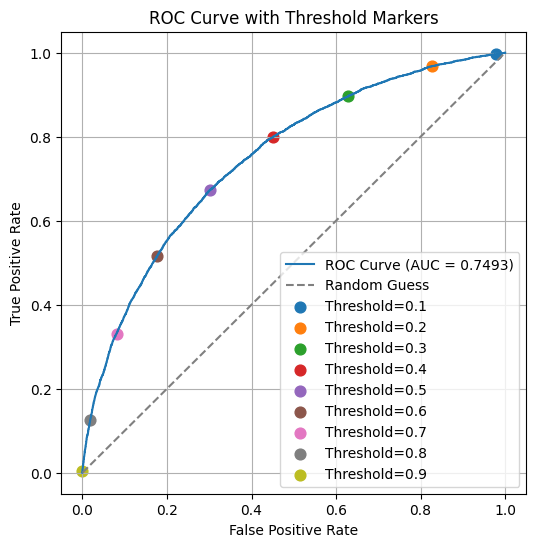

In [5]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

print(f"\nMean AUC: {sum(auc_scores) / len(auc_scores):.4f}")


# FPR, TPR, Thresholds の取得
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.4f})".format(roc_auc_score(y_val, y_pred)))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

# 特定のしきい値をマーク
for target_thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ]:
    idx = (np.abs(thresholds - target_thresh)).argmin()
    plt.scatter(fpr[idx], tpr[idx], label=f"Threshold={target_thresh}", s=60)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Threshold Markers")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

thresholds_to_test = np.arange(0.1, 1.0, 0.1)

confusion_data = []

for thresh in thresholds_to_test:
    y_pred_label = (y_pred >= thresh).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_label).ravel()
    
    confusion_data.append({
        'Threshold': round(thresh, 2),
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Recall (TPR)': round(tp / (tp + fn + 1e-9), 3),
        'Precision': round(tp / (tp + fp + 1e-9), 3)
    })

df_confusion = pd.DataFrame(confusion_data)
display(df_confusion)


,Threshold,TP,FP,TN,FN,Recall (TPR),Precision
0,0.1,4948,55301,1236,17,0.997,0.082
1,0.2,4806,46769,9768,159,0.968,0.093
2,0.3,4456,35596,20941,509,0.897,0.111
3,0.4,3971,25507,31030,994,0.800,0.135
4,0.5,3342,17059,39478,1623,0.673,0.164
5,0.6,2561,9983,46554,2404,0.516,0.204
6,0.7,1645,4565,51972,3320,0.331,0.265
7,0.8,628,1055,55482,4337,0.126,0.373
8,0.9,19,10,56527,4946,0.004,0.655


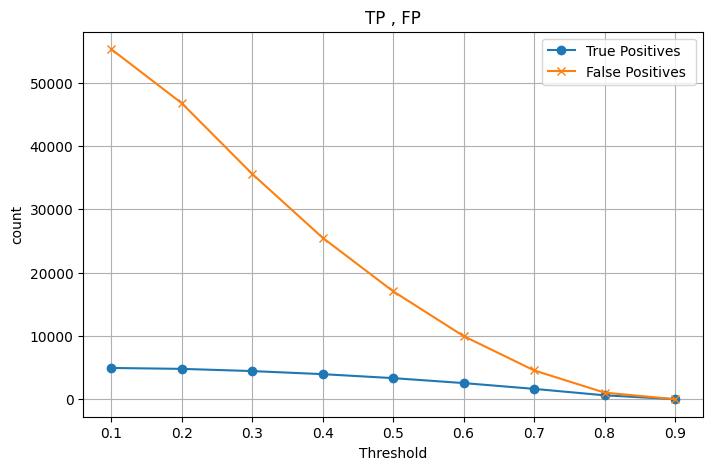

In [7]:
import matplotlib.pyplot as plt

# X軸（threshold）
thresholds = df_confusion['Threshold']

# Y軸（TP, FP）
tp_values = df_confusion['TP']
fp_values = df_confusion['FP']

plt.figure(figsize=(8, 5))
plt.plot(thresholds, tp_values, label='True Positives', marker='o')
plt.plot(thresholds, fp_values, label='False Positives ', marker='x')

plt.xlabel('Threshold')
plt.ylabel('count')
plt.title('TP , FP')
plt.legend()
plt.grid(True)
plt.xticks(thresholds)
plt.show()


In [8]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # 特徴量の重要度（splitベース）
# importances = model.feature_importances_
# feature_names = X_train.columns

# # 可視化
# importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
# importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# plt.figure(figsize=(8,5))
# plt.barh(importance_df['Feature'], importance_df['Importance'])
# plt.gca().invert_yaxis()
# plt.title("LightGBM Feature Importances")
# plt.show()


In [10]:
import pandas as pd
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap_df = pd.DataFrame(shap_values, columns=X_val.columns, index=X_val.index)

display(shap_df.head())

shap_summary_df = pd.DataFrame({
    'Mean(|SHAP|)': shap_df.abs().mean(),
}).sort_values(by='Mean(|SHAP|)', ascending=False)

display(shap_summary_df)

/opt/anaconda3/envs/home-credit-default-risk/lib/python3.10/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


,CNT_CHILDREN,AMT_INCOME_TOTAL,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,DAYS_EMPLOYED,DAYS_REGISTRATION,AMT_ANNUITY,...,CNT_INSTALMENT_MATURE_CUM_SUM,CNT_DRAWINGS_CURRENT_SUM,AMT_TOTAL_RECEIVABLE_SUM,AMT_INST_MIN_REGULARITY_MEAN,AMT_DRAWINGS_CURRENT_SUM,AMT_DRAWINGS_CURRENT_MEAN,AMT_DRAWINGS_CURRENT_STD,AMT_DRAWINGS_POS_CURRENT_SUM,AMT_DRAWINGS_POS_CURRENT_MEAN,AMT_DRAWINGS_POS_CURRENT_STD
1,0.002382,-0.119647,0.169663,-0.233828,0.203384,0.115796,-0.124941,0.117648,-0.000027,0.158300,...,0.006376,-0.014077,-0.000941,-0.007684,0.001109,-0.016139,0.007406,0.014747,-0.000972,-0.003349
4,0.001509,0.026652,0.101468,0.478089,0.280372,-0.094062,0.075481,-0.075904,0.016519,0.035661,...,0.005500,-0.012278,-0.000702,-0.002598,0.001892,-0.019019,0.009861,0.012811,-0.000470,-0.003007
11,-0.003027,0.097825,-0.499229,-0.030873,-0.508560,-0.054167,-0.368224,-0.010000,0.001211,-0.166394,...,0.020633,0.000161,0.003600,-0.006017,0.006820,-0.026256,0.015342,0.011540,-0.005320,-0.005841
13,-0.002269,-0.042894,0.145366,-0.127659,-0.663242,0.040757,-0.113954,-0.111112,0.014200,0.098956,...,0.003691,-0.012672,-0.002100,-0.005349,0.001274,-0.035788,0.010637,0.011655,-0.000292,-0.004814
15,-0.004011,0.032279,0.906934,0.416639,-0.432763,-0.124655,0.101047,0.124822,0.029738,0.013081,...,0.007146,-0.015640,-0.001016,-0.000539,0.004708,-0.013684,0.012038,0.015064,-0.001172,-0.003539


,Mean(|SHAP|)
EXT_SOURCE_3,0.406856
EXT_SOURCE_2,0.368210
EXT_SOURCE_1,0.225225
AMT_ANNUITY,0.122105
DAYS_EMPLOYED,0.113676
DAYS_BIRTH,0.104136
AMT_CREDIT,0.092138
AMT_DRAWINGS_CURRENT_MEAN,0.046702
CNT_DRAWINGS_ATM_CURRENT_SUM,0.044426
AMT_INCOME_TOTAL,0.044066
